In [1]:
import os
import argparse

import torch
import os
import argparse
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as transforms

from os2d.modeling.model import build_os2d_from_config
from os2d.config import cfg
import  os2d.utils.visualization as visualizer
from os2d.structures.feature_map import FeatureMapSize
from os2d.utils import setup_logger, read_image, get_image_size_after_resize_preserving_aspect_ratio
from os2d.data import dataloader
from os2d.modeling.model import build_os2d_from_config

from os2d.data.dataloader import build_eval_dataloaders_from_cfg, build_train_dataloader_from_config
from os2d.engine.train import trainval_loop
from os2d.utils import set_random_seed, get_trainable_parameters, mkdir, save_config, setup_logger, get_data_path
from os2d.engine.optimization import create_optimizer
from os2d.config import cfg
from os2d.utils.visualization import *
import random
import os2d.utils.visualization as visualizer
from pathlib import Path
import cv2
import numpy as np
from os2d.utils import get_image_size_after_resize_preserving_aspect_ratio
from src.util.detection import generate_detection_boxes
from src.util.visualize import visualize_boxes_on_image
from src.util.filter import DataLoaderDB

### INIT

In [3]:
import torch

def show_gpu_memory_usage():
    """顯示當前 GPU RAM 使用情況"""
    if torch.cuda.is_available():
        device = torch.cuda.current_device()
        device_name = torch.cuda.get_device_name(device)

        # 獲取記憶體使用情況 (轉換為 GB)
        allocated = torch.cuda.memory_allocated(device) / 1024**3
        reserved = torch.cuda.memory_reserved(device) / 1024**3
        total = torch.cuda.get_device_properties(device).total_memory / 1024**3

        print(f"🖥️  GPU 設備: {device_name}")
        print(f"📊 記憶體使用情況:")
        print(f"   已分配: {allocated:.2f} GB")
        print(f"   已保留: {reserved:.2f} GB")
        print(f"   總容量: {total:.2f} GB")
        print(f"   使用率: {(allocated/total)*100:.1f}%")
        print(f"   保留率: {(reserved/total)*100:.1f}%")

        # 視覺化進度條
        usage_percent = int((allocated/total)*100)
        bar_length = 20
        filled_length = int(bar_length * usage_percent / 100)
        bar = '█' * filled_length + '░' * (bar_length - filled_length)
        print(f"   [{bar}] {usage_percent}%")

    else:
        print("❌ CUDA 不可用，無法檢測 GPU 記憶體")

import torch

def count_parameters(model):
    """
    計算模型的參數數量
    Returns:
      total_params: 包含所有參數
      trainable_params: 只包含 requires_grad=True 的參數
    """
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

import io

def estimate_model_size(model):
    """
    將模型序列化到緩衝區，估算存檔大小（MB）
    """
    buffer = io.BytesIO()
    torch.save(model.state_dict(), buffer)
    size_mb = buffer.getbuffer().nbytes / (1024 ** 2)
    return size_mb

def show_network_status( orig_net, prune_net ):
    print( "原始網路參數統計:\n" )
    model = orig_net
    total, trainable = count_parameters(model)
    print(f"總參數量: {total:,}")
    print(f"可訓練參數量: {trainable:,}")

    size_mb = estimate_model_size(model)
    print(f"模型存儲大小: {size_mb:.2f} MB")

    print( "剪枝網路參數統計:\n" )
    model = prune_net
    total, trainable = count_parameters(model)
    print(f"總參數量: {total:,}")
    print(f"可訓練參數量: {trainable:,}")

    size_mb = estimate_model_size(model)
    print(f"模型存儲大小: {size_mb:.2f} MB")

In [4]:
if cfg.is_cuda:
    assert torch.cuda.is_available(), "Do not have available GPU, but cfg.is_cuda == 1"
    torch.backends.cudnn.benchmark = True

# random seed
set_random_seed(cfg.random_seed, cfg.is_cuda)

# Model
net, box_coder, criterion, img_normalization, optimizer_state = build_os2d_from_config(cfg)

# Optimizer
parameters = get_trainable_parameters(net)
optimizer = create_optimizer(parameters, cfg.train.optim, optimizer_state)

# load the dataset
data_path = get_data_path()
dataloader_train, datasets_train_for_eval = build_train_dataloader_from_config(cfg, box_coder, img_normalization,
                                                                                data_path=data_path)

dataloaders_eval = build_eval_dataloaders_from_cfg(cfg, box_coder, img_normalization,
                                                    datasets_for_eval=datasets_train_for_eval,
                                                    data_path=data_path)

db = DataLoaderDB( path = './src/db/data.csv' , dataloader = dataloader_train)

In [5]:
from src.lcp.ct_aoi_align import ContextAoiAlign
transform_image = transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Normalize(img_normalization["mean"], img_normalization["std"])
                      ])

context_aoi_align = ContextAoiAlign( db, dataloader_train, transform_image , net , cfg )

In [6]:
from src.lcp.aux_net import AuxiliaryNetwork
aux_net = AuxiliaryNetwork( context_aoi_align, db )

In [7]:
from src.lcp.lcp import LCP
lcp = LCP(net, aux_net, dataloader_train)
lcp.init_for_indices()

[LCP] 初始化完成，共 43 層的 channel 索引


In [8]:
from src.util.prune_db import PruneDBControler
prune_db = PruneDBControler( path = './src/db/prune_channel_information.csv' )
prune_db.initial()

檔案 ./src/db/prune_channel_information.csv 已存在，將刪除並重新創建。
創建新檔案: ./src/db/prune_channel_information.csv
檔案 ./src/db/prune_channel_information.csv 初始化完成。


In [9]:
from src.lcp.pruner import Pruner
pruner = Pruner( lcp._prune_net )
pruner.set_prune_db( prune_db )

In [10]:
layers = lcp.get_layers_name()
print( layers )
layer_names = []
for name, ch in layers:
    if name.endswith('.conv1') or name.endswith('.conv2'):
        layer_names.append( name )

[('conv1', 64), ('layer1.0.conv1', 64), ('layer1.0.conv2', 64), ('layer1.0.conv3', 256), ('layer1.0.downsample.0', 256), ('layer1.1.conv1', 64), ('layer1.1.conv2', 64), ('layer1.1.conv3', 256), ('layer1.2.conv1', 64), ('layer1.2.conv2', 64), ('layer1.2.conv3', 256), ('layer2.0.conv1', 128), ('layer2.0.conv2', 128), ('layer2.0.conv3', 512), ('layer2.0.downsample.0', 512), ('layer2.1.conv1', 128), ('layer2.1.conv2', 128), ('layer2.1.conv3', 512), ('layer2.2.conv1', 128), ('layer2.2.conv2', 128), ('layer2.2.conv3', 512), ('layer2.3.conv1', 128), ('layer2.3.conv2', 128), ('layer2.3.conv3', 512), ('layer3.0.conv1', 256), ('layer3.0.conv2', 256), ('layer3.0.conv3', 1024), ('layer3.0.downsample.0', 1024), ('layer3.1.conv1', 256), ('layer3.1.conv2', 256), ('layer3.1.conv3', 1024), ('layer3.2.conv1', 256), ('layer3.2.conv2', 256), ('layer3.2.conv3', 1024), ('layer3.3.conv1', 256), ('layer3.3.conv2', 256), ('layer3.3.conv3', 1024), ('layer3.4.conv1', 256), ('layer3.4.conv2', 256), ('layer3.4.con

In [11]:
lcp.set_prune_db(prune_db)

In [12]:
from src.lcp.lcpfinetune import LCPFineTune
lcp_finetune = LCPFineTune(
    prune_net = lcp._prune_net,
    dataloader_train = dataloader_train,
    img_normalization = img_normalization,
    box_coder = box_coder,
    cfg       = cfg,
    optimizer=optimizer,
    parameters=parameters
)
lcp_finetune._setup_logging()

#### Try one layer for channel selection computing for Test SetUp

In [14]:

for name, ch in layers:
    if name == 'layer2.0.conv2':
        pass
    else:
        continue
    print(f"{name}: {ch} channels")
    keep, discard = lcp.get_channel_selection_by_no_grad(
        layer_name   = f"net_feature_maps.{name}",
        discard_rate = 0.5,
        lambda_rate  = 1.0,
        use_image_num= 3,
        random_seed  = 42
    )
    print(f"layer {name} , 預計保留通道數量: {len(keep)}/{ch}, 預計捨棄通道數量: {len(discard)}/{ch}")

layer2.0.conv2: 128 channels
[LCP] 開始基於數學推導的無梯度通道重要性計算 - net_feature_maps.layer2.0.conv2
[415, 393, 77]
[LOG] 原始網路特徵提取完成
[LOG] 剪枝網路特徵提取完成
415 {'channels': [{'l1_norm': 0.48384854197502136, 'variance': 0.30947673320770264, 'mean_deviation': 0.23418404161930084, 'energy': 0.4397299885749817, 'sparsity': 0.0, 'importance': 0.40194079279899597}, {'l1_norm': 0.6393678784370422, 'variance': 0.2685675323009491, 'mean_deviation': 0.426891565322876, 'energy': 0.5750613808631897, 'sparsity': 0.0, 'importance': 0.4821745753288269}, {'l1_norm': 1.8122285604476929, 'variance': 0.6163132190704346, 'mean_deviation': 1.8953920602798462, 'energy': 3.744446277618408, 'sparsity': 0.0, 'importance': 1.4107061624526978}, {'l1_norm': 1.4037833213806152, 'variance': 0.33581170439720154, 'mean_deviation': 1.5062073469161987, 'energy': 2.238748788833618, 'sparsity': 0.0, 'importance': 1.0426957607269287}, {'l1_norm': 3.5616633892059326, 'variance': 0.17837855219841003, 'mean_deviation': 3.434929132461548, 'ene

### Main For Prune + Finetune

##### Set Up for config

In [17]:
cfg.defrost()

cfg.train.optim.max_iter = 30
cfg.train.do_training = True
cfg.output.print_iter = 5
cfg.eval.iter = 20
cfg.train.batch_size = 4

cfg.freeze()


In [18]:
from src.util.loss import LCPFinetuneCriterion
lcp_criterion = LCPFinetuneCriterion(
    original_criterion=criterion,  # 原始損失函數實例
    aux_net=lcp._aux_net,  # 包含 aux_loss 方法的實例
    auxiliary_weight=1.0  # 可以調整輔助損失權重
)

#### Load Pruned Network

In [20]:
# from src.lcp.recontruction import LCPReconstruction
# lcp_reconstruction = LCPReconstruction(
#     prune_db = prune_db,
#     pruner = pruner,
#     prune_net = lcp._prune_net
# )

In [21]:
# lcp_reconstruction.load_checkpoint_with_pruned_net(
#     './src/util/checkpoints-test/checkpoint_lcp_finetune_26_layer3.5.conv2.pth'
# )
# lcp._prune_net = lcp_reconstruction._prune_net
# pruned_layers = []
# for layer in lcp_reconstruction._pruned_layers:
#     if layer not in pruned_layers:
#         pruned_layers.append(layer)
# for layer in pruned_layers:
#     lcp.prune_layer(
#         layer_name   = layer,
#         discard_rate = None,
#     )

##### Main code for LCP Algorithm 1

[LCP] 開始基於數學推導的無梯度通道重要性計算 - net_feature_maps.layer1.0.conv1
[415, 393, 77]
[LOG] 原始網路特徵提取完成
[LOG] 剪枝網路特徵提取完成
415 {'channels': [{'l1_norm': 3.165086269378662, 'variance': 0.3043505847454071, 'mean_deviation': 1.8900401592254639, 'energy': 10.32211971282959, 'sparsity': 0.0, 'importance': 1.1527749300003052}, {'l1_norm': 3.236215591430664, 'variance': 1.319017767906189, 'mean_deviation': 1.9611694812774658, 'energy': 11.792101860046387, 'sparsity': 0.0, 'importance': 1.2666047811508179}, {'l1_norm': 1.7513906955718994, 'variance': 0.7748582363128662, 'mean_deviation': 0.4760693311691284, 'energy': 3.8412582874298096, 'sparsity': 0.0, 'importance': 0.6139687299728394}, {'l1_norm': 0.6462940573692322, 'variance': 0.10277213156223297, 'mean_deviation': 1.921334147453308, 'energy': 0.5204595327377319, 'sparsity': 0.0, 'importance': 0.449018657207489}, {'l1_norm': 3.1679792404174805, 'variance': 9.109703063964844, 'mean_deviation': 1.44181489944458, 'energy': 16.4909725189209, 'sparsity': 0.0

c:\Users\marti\anaconda3\envs\ntut-project\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[LCP Debug] Computing auxiliary loss...
[LCP Debug] batch_idx is None: False
[LCP Debug] aux_net is None: False
[Memory] 函數開始: 已分配 5.06 GB, 已保留 6.22 GB
[Memory] 獲取 image_ids 後: 已分配 5.06 GB, 已保留 6.22 GB
Image 54 size FeatureMapSize(w=3264, h=2448) has 7 boxes
Image 502 size FeatureMapSize(w=3264, h=2448) has 7 boxes
Image 403 size FeatureMapSize(w=3264, h=2448) has 4 boxes
Image 672 size FeatureMapSize(w=3264, h=2448) has 16 boxes
[Memory] 批次資料解包後: 已分配 5.06 GB, 已保留 5.23 GB
[LCP Debug] class_ids type: <class 'list'>
[LCP Debug] class_ids length: 12
[LCP Debug] class_ids[0] type: <class 'numpy.int64'>
[Memory] 處理 image_id 0: 已分配 5.06 GB, 已保留 5.23 GB
[LCP Debug] Sample 1: aux_loss = 4.504997
[LCP Debug] Sample 2: aux_loss = 4.833220
[Memory] 批次資料清理後: 已分配 5.06 GB, 已保留 5.23 GB
[LCP Debug] Total samples processed: 2/4
[LCP Debug] Average auxiliary loss: 4.669108
[Memory] 函數結束: 已分配 5.06 GB, 已保留 5.23 GB
[Memory] 最終清理後: 已分配 5.06 GB, 已保留 5.23 GB
[LCP Loss] Original loss: 0.347270 (valid: True)
[L

[2025-07-18 09:21:43,714] [LCP.FineTune] [INFO] LCP Fine-tune 完成


🖥️  GPU 設備: NVIDIA GeForce GTX 1650 Ti
📊 記憶體使用情況:
   已分配: 0.14 GB
   已保留: 3.29 GB
   總容量: 4.00 GB
   使用率: 3.5%
   保留率: 82.3%
   [░░░░░░░░░░░░░░░░░░░░] 3%
剪枝後網路狀態 (第 1, layer1.0.conv1 層):
原始網路參數統計:

總參數量: 10,169,478
可訓練參數量: 10,169,478
模型存儲大小: 39.05 MB
剪枝網路參數統計:

總參數量: 10,136,736
可訓練參數量: 10,136,736
模型存儲大小: 38.92 MB
image to show size: (3264, 2448), res


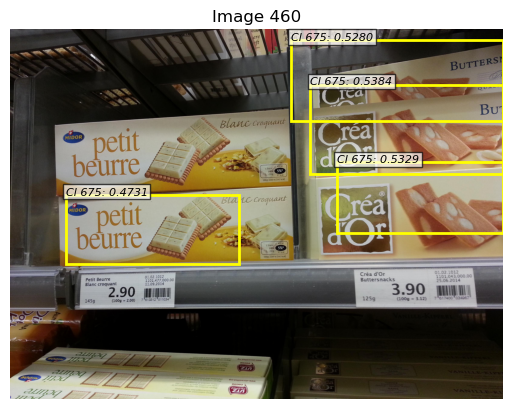

[LCP] 開始基於數學推導的無梯度通道重要性計算 - net_feature_maps.layer1.0.conv2
[415, 393, 77]
[LOG] 原始網路特徵提取完成
[LOG] 剪枝網路特徵提取完成
415 {'channels': [{'l1_norm': 0.6759385466575623, 'variance': 0.27290475368499756, 'mean_deviation': 0.43850821256637573, 'energy': 0.655971109867096, 'sparsity': 0.0, 'importance': 0.3661152720451355}, {'l1_norm': 2.075479745864868, 'variance': 0.5185167193412781, 'mean_deviation': 1.8942210674285889, 'energy': 4.822635173797607, 'sparsity': 0.0, 'importance': 0.9930770397186279}, {'l1_norm': 0.6809918284416199, 'variance': 0.21698008477687836, 'mean_deviation': 0.4281390905380249, 'energy': 0.5873189568519592, 'sparsity': 0.0, 'importance': 0.3587723970413208}, {'l1_norm': 2.2114222049713135, 'variance': 2.437053918838501, 'mean_deviation': 2.381248712539673, 'energy': 7.280697345733643, 'sparsity': 0.0, 'importance': 1.3181005716323853}, {'l1_norm': 0.40419408679008484, 'variance': 0.14586955308914185, 'mean_deviation': 0.139164537191391, 'energy': 0.24800081551074982, 'spars

[2025-07-18 09:35:33,662] [LCP.FineTune] [INFO] LCP Fine-tune 完成


🖥️  GPU 設備: NVIDIA GeForce GTX 1650 Ti
📊 記憶體使用情況:
   已分配: 0.15 GB
   已保留: 3.20 GB
   總容量: 4.00 GB
   使用率: 3.9%
   保留率: 80.0%
   [░░░░░░░░░░░░░░░░░░░░] 3%
剪枝後網路狀態 (第 2, layer1.0.conv2 層):
原始網路參數統計:

總參數量: 10,169,478
可訓練參數量: 10,169,478
模型存儲大小: 39.05 MB
剪枝網路參數統計:

總參數量: 10,117,611
可訓練參數量: 10,117,611
模型存儲大小: 38.85 MB
image to show size: (3264, 2448), res


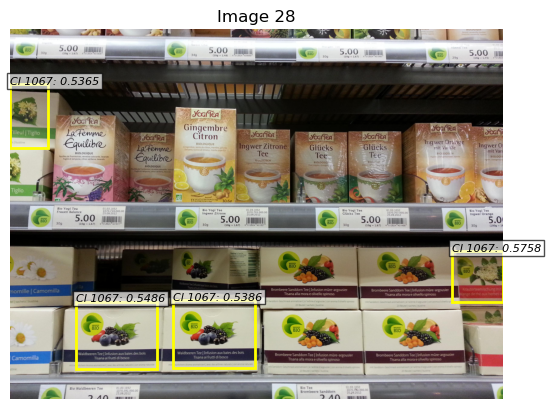

[LCP] 開始基於數學推導的無梯度通道重要性計算 - net_feature_maps.layer1.1.conv1
[415, 393, 77]
[LOG] 原始網路特徵提取完成
[LOG] 剪枝網路特徵提取完成
415 {'channels': [{'l1_norm': 0.6239269375801086, 'variance': 0.572658360004425, 'mean_deviation': 0.4078204035758972, 'energy': 0.6411094069480896, 'sparsity': 0.0, 'importance': 0.6679520606994629}, {'l1_norm': 0.6124867796897888, 'variance': 0.6183605790138245, 'mean_deviation': 0.3058609962463379, 'energy': 0.6438538432121277, 'sparsity': 7.106058092176681e-06, 'importance': 0.6534489393234253}, {'l1_norm': 0.5526039004325867, 'variance': 0.6698921918869019, 'mean_deviation': 0.05163208395242691, 'energy': 0.6788269281387329, 'sparsity': 7.106058092176681e-06, 'importance': 0.5981679558753967}, {'l1_norm': 0.733701229095459, 'variance': 0.5453314781188965, 'mean_deviation': 0.5026496648788452, 'energy': 0.9663091897964478, 'sparsity': 0.0, 'importance': 0.7708981037139893}, {'l1_norm': 0.4071585237979889, 'variance': 0.23743878304958344, 'mean_deviation': 0.1788521707057953,

C:\Users\marti\os2d-in-Channel-Prune\os2d\engine\objective.py:275: UserWarning: Number of positives in a batch cannot be zero, can't normalize this way, setting num_pos to 1
  warnings.warn("Number of positives in a batch cannot be zero, can't normalize this way, setting num_pos to 1")


[LCP Debug] Computing auxiliary loss...
[LCP Debug] batch_idx is None: False
[LCP Debug] aux_net is None: False
[Memory] 函數開始: 已分配 5.01 GB, 已保留 6.17 GB
[Memory] 獲取 image_ids 後: 已分配 5.01 GB, 已保留 6.17 GB
Image 394 size FeatureMapSize(w=3264, h=2448) has 13 boxes
Image 516 size FeatureMapSize(w=2448, h=3264) has 10 boxes
Image 479 size FeatureMapSize(w=3264, h=2448) has 11 boxes
Image 48 size FeatureMapSize(w=3264, h=2448) has 11 boxes
[Memory] 批次資料解包後: 已分配 5.01 GB, 已保留 5.21 GB
[LCP Debug] class_ids type: <class 'list'>
[LCP Debug] class_ids length: 14
[LCP Debug] class_ids[0] type: <class 'numpy.int64'>
[Memory] 處理 image_id 0: 已分配 5.01 GB, 已保留 5.21 GB
[LCP Debug] Sample 1: aux_loss = 4.676755
[LCP Debug] Sample 2: aux_loss = 4.629150
[Memory] 批次資料清理後: 已分配 5.01 GB, 已保留 5.21 GB
[LCP Debug] Total samples processed: 2/4
[LCP Debug] Average auxiliary loss: 4.652953
[Memory] 函數結束: 已分配 5.01 GB, 已保留 5.21 GB
[Memory] 最終清理後: 已分配 5.01 GB, 已保留 5.21 GB
[LCP Loss] Original loss: 1.073771 (valid: True)

C:\Users\marti\os2d-in-Channel-Prune\os2d\engine\objective.py:275: UserWarning: Number of positives in a batch cannot be zero, can't normalize this way, setting num_pos to 1
  warnings.warn("Number of positives in a batch cannot be zero, can't normalize this way, setting num_pos to 1")


[LCP Debug] Computing auxiliary loss...
[LCP Debug] batch_idx is None: False
[LCP Debug] aux_net is None: False
[Memory] 函數開始: 已分配 5.02 GB, 已保留 6.19 GB
[Memory] 獲取 image_ids 後: 已分配 5.02 GB, 已保留 6.19 GB
Image 293 size FeatureMapSize(w=2448, h=3264) has 6 boxes
Image 649 size FeatureMapSize(w=2448, h=3264) has 14 boxes
Image 529 size FeatureMapSize(w=3264, h=2448) has 6 boxes
Image 230 size FeatureMapSize(w=2448, h=3264) has 11 boxes
[Memory] 批次資料解包後: 已分配 5.02 GB, 已保留 5.18 GB
[LCP Debug] class_ids type: <class 'list'>
[LCP Debug] class_ids length: 15
[LCP Debug] class_ids[0] type: <class 'numpy.int64'>
[Memory] 處理 image_id 0: 已分配 5.02 GB, 已保留 5.18 GB
[LCP Debug] Sample 1: aux_loss = 4.501645
[Memory] 批次資料清理後: 已分配 5.02 GB, 已保留 5.18 GB
[LCP Debug] Total samples processed: 1/4
[LCP Debug] Average auxiliary loss: 4.501645
[Memory] 函數結束: 已分配 5.02 GB, 已保留 5.18 GB
[Memory] 最終清理後: 已分配 5.02 GB, 已保留 5.18 GB
[LCP Loss] Original loss: 0.650753 (valid: True)
[LCP Loss] Auxiliary loss: 4.501645 (valid

C:\Users\marti\os2d-in-Channel-Prune\os2d\engine\objective.py:275: UserWarning: Number of positives in a batch cannot be zero, can't normalize this way, setting num_pos to 1
  warnings.warn("Number of positives in a batch cannot be zero, can't normalize this way, setting num_pos to 1")


[LCP Debug] Computing auxiliary loss...
[LCP Debug] batch_idx is None: False
[LCP Debug] aux_net is None: False
[Memory] 函數開始: 已分配 4.84 GB, 已保留 5.92 GB
[Memory] 獲取 image_ids 後: 已分配 4.84 GB, 已保留 5.92 GB
Image 127 size FeatureMapSize(w=3264, h=2448) has 13 boxes
Image 380 size FeatureMapSize(w=3264, h=2448) has 12 boxes
Image 418 size FeatureMapSize(w=2448, h=3264) has 8 boxes
Image 222 size FeatureMapSize(w=3264, h=2448) has 8 boxes
[Memory] 批次資料解包後: 已分配 4.84 GB, 已保留 5.03 GB
[LCP Debug] class_ids type: <class 'list'>
[LCP Debug] class_ids length: 14
[LCP Debug] class_ids[0] type: <class 'numpy.int64'>
[Memory] 處理 image_id 0: 已分配 4.84 GB, 已保留 5.03 GB
[Memory] 批次資料清理後: 已分配 4.84 GB, 已保留 5.03 GB
[LCP Debug] No valid samples processed, returning zero loss
[Memory] 最終清理後: 已分配 4.84 GB, 已保留 5.03 GB
[LCP Loss] Original loss: 0.415132 (valid: True)
[LCP Loss] Auxiliary loss: 0.000000 (valid: False)
[LCP Warning] ❌ Auxiliary loss is invalid (≤ 1e-6)
[LCP Info] 🚫 Loss combination skipped - invalid 

C:\Users\marti\os2d-in-Channel-Prune\os2d\engine\objective.py:275: UserWarning: Number of positives in a batch cannot be zero, can't normalize this way, setting num_pos to 1
  warnings.warn("Number of positives in a batch cannot be zero, can't normalize this way, setting num_pos to 1")


[LCP Debug] Computing auxiliary loss...
[LCP Debug] batch_idx is None: False
[LCP Debug] aux_net is None: False
[Memory] 函數開始: 已分配 5.02 GB, 已保留 6.17 GB
[Memory] 獲取 image_ids 後: 已分配 5.02 GB, 已保留 6.17 GB
Image 137 size FeatureMapSize(w=3264, h=2448) has 13 boxes
Image 281 size FeatureMapSize(w=2448, h=3264) has 8 boxes
Image 100 size FeatureMapSize(w=2448, h=3264) has 7 boxes
Image 670 size FeatureMapSize(w=3264, h=2448) has 12 boxes
[Memory] 批次資料解包後: 已分配 5.02 GB, 已保留 5.19 GB
[LCP Debug] class_ids type: <class 'list'>
[LCP Debug] class_ids length: 14
[LCP Debug] class_ids[0] type: <class 'numpy.int64'>
[Memory] 處理 image_id 0: 已分配 5.02 GB, 已保留 5.19 GB
[LCP Debug] Sample 1: aux_loss = 4.574539
[Memory] 批次資料清理後: 已分配 5.02 GB, 已保留 5.19 GB
[LCP Debug] Total samples processed: 1/4
[LCP Debug] Average auxiliary loss: 4.574539
[Memory] 函數結束: 已分配 5.02 GB, 已保留 5.19 GB
[Memory] 最終清理後: 已分配 5.02 GB, 已保留 5.19 GB
[LCP Loss] Original loss: 1.139510 (valid: True)
[LCP Loss] Auxiliary loss: 4.574539 (valid

[2025-07-18 09:49:11,542] [LCP.FineTune] [INFO] LCP Fine-tune 完成


🖥️  GPU 設備: NVIDIA GeForce GTX 1650 Ti
📊 記憶體使用情況:
   已分配: 0.17 GB
   已保留: 3.34 GB
   總容量: 4.00 GB
   使用率: 4.2%
   保留率: 83.5%
   [░░░░░░░░░░░░░░░░░░░░] 4%
剪枝後網路狀態 (第 3, layer1.1.conv1 層):
原始網路參數統計:

總參數量: 10,169,478
可訓練參數量: 10,169,478
模型存儲大小: 39.05 MB
剪枝網路參數統計:

總參數量: 10,075,077
可訓練參數量: 10,075,077
模型存儲大小: 38.69 MB
image to show size: (3264, 2448), res


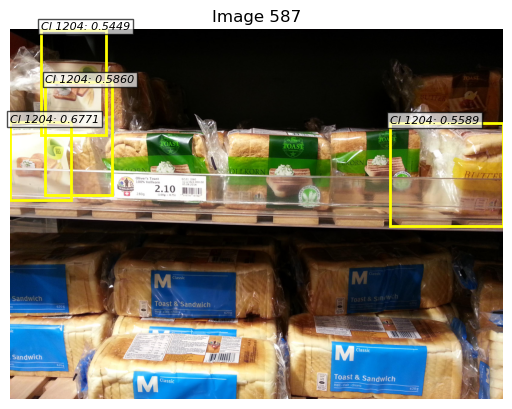

[LCP] 開始基於數學推導的無梯度通道重要性計算 - net_feature_maps.layer1.1.conv2
[415, 393, 77]
[LOG] 原始網路特徵提取完成
[LOG] 剪枝網路特徵提取完成
415 {'channels': [{'l1_norm': 0.45870256423950195, 'variance': 0.3090077340602875, 'mean_deviation': 0.1271819770336151, 'energy': 0.3187550902366638, 'sparsity': 0.0, 'importance': 0.5480570197105408}, {'l1_norm': 0.4667377769947052, 'variance': 0.37960556149482727, 'mean_deviation': 0.39449551701545715, 'energy': 0.4080200493335724, 'sparsity': 0.0, 'importance': 0.6674237251281738}, {'l1_norm': 0.4730754792690277, 'variance': 0.40903013944625854, 'mean_deviation': 0.32086649537086487, 'energy': 0.41804176568984985, 'sparsity': 0.0, 'importance': 0.6632499694824219}, {'l1_norm': 0.4244533181190491, 'variance': 0.22369615733623505, 'mean_deviation': 0.08971460163593292, 'energy': 0.32332074642181396, 'sparsity': 0.0, 'importance': 0.49716630578041077}, {'l1_norm': 0.6425953507423401, 'variance': 0.197424978017807, 'mean_deviation': 0.3859756588935852, 'energy': 0.57184159755706

C:\Users\marti\os2d-in-Channel-Prune\os2d\engine\objective.py:275: UserWarning: Number of positives in a batch cannot be zero, can't normalize this way, setting num_pos to 1
  warnings.warn("Number of positives in a batch cannot be zero, can't normalize this way, setting num_pos to 1")


[LCP Debug] Computing auxiliary loss...
[LCP Debug] batch_idx is None: False
[LCP Debug] aux_net is None: False
[Memory] 函數開始: 已分配 4.79 GB, 已保留 5.88 GB
[Memory] 獲取 image_ids 後: 已分配 4.79 GB, 已保留 5.88 GB
Image 551 size FeatureMapSize(w=2448, h=3264) has 12 boxes
Image 386 size FeatureMapSize(w=3264, h=2448) has 12 boxes
Image 274 size FeatureMapSize(w=3264, h=2448) has 11 boxes
Image 475 size FeatureMapSize(w=3264, h=2448) has 7 boxes
[Memory] 批次資料解包後: 已分配 4.79 GB, 已保留 4.99 GB
[LCP Debug] class_ids type: <class 'list'>
[LCP Debug] class_ids length: 15
[LCP Debug] class_ids[0] type: <class 'numpy.int64'>
[Memory] 處理 image_id 0: 已分配 4.79 GB, 已保留 4.99 GB
[LCP Debug] Sample 1: aux_loss = 4.515631
[Memory] 批次資料清理後: 已分配 4.79 GB, 已保留 4.99 GB
[LCP Debug] Total samples processed: 1/4
[LCP Debug] Average auxiliary loss: 4.515631
[Memory] 函數結束: 已分配 4.79 GB, 已保留 4.99 GB
[Memory] 最終清理後: 已分配 4.79 GB, 已保留 4.99 GB
[LCP Loss] Original loss: 6.868809 (valid: True)
[LCP Loss] Auxiliary loss: 4.515631 (vali

C:\Users\marti\os2d-in-Channel-Prune\os2d\engine\objective.py:275: UserWarning: Number of positives in a batch cannot be zero, can't normalize this way, setting num_pos to 1
  warnings.warn("Number of positives in a batch cannot be zero, can't normalize this way, setting num_pos to 1")


[LCP Debug] Computing auxiliary loss...
[LCP Debug] batch_idx is None: False
[LCP Debug] aux_net is None: False
[Memory] 函數開始: 已分配 4.98 GB, 已保留 6.13 GB
[Memory] 獲取 image_ids 後: 已分配 4.98 GB, 已保留 6.13 GB
Image 247 size FeatureMapSize(w=2448, h=3264) has 13 boxes
Image 316 size FeatureMapSize(w=3264, h=2448) has 18 boxes
Image 425 size FeatureMapSize(w=2448, h=3264) has 7 boxes
Image 574 size FeatureMapSize(w=3264, h=2448) has 15 boxes
[Memory] 批次資料解包後: 已分配 4.98 GB, 已保留 5.18 GB
[LCP Debug] class_ids type: <class 'list'>
[LCP Debug] class_ids length: 15
[LCP Debug] class_ids[0] type: <class 'numpy.int64'>
[Memory] 處理 image_id 0: 已分配 4.98 GB, 已保留 5.18 GB
[LCP Debug] Sample 1: aux_loss = 4.533351
[Memory] 批次資料清理後: 已分配 4.98 GB, 已保留 5.18 GB
[LCP Debug] Total samples processed: 1/4
[LCP Debug] Average auxiliary loss: 4.533351
[Memory] 函數結束: 已分配 4.98 GB, 已保留 5.18 GB
[Memory] 最終清理後: 已分配 4.98 GB, 已保留 5.18 GB
[LCP Loss] Original loss: 1.005067 (valid: True)
[LCP Loss] Auxiliary loss: 4.533351 (vali

C:\Users\marti\os2d-in-Channel-Prune\os2d\engine\objective.py:275: UserWarning: Number of positives in a batch cannot be zero, can't normalize this way, setting num_pos to 1
  warnings.warn("Number of positives in a batch cannot be zero, can't normalize this way, setting num_pos to 1")


[LCP Debug] Computing auxiliary loss...
[LCP Debug] batch_idx is None: False
[LCP Debug] aux_net is None: False
[Memory] 函數開始: 已分配 4.98 GB, 已保留 6.15 GB
[Memory] 獲取 image_ids 後: 已分配 4.98 GB, 已保留 6.15 GB
Image 182 size FeatureMapSize(w=3264, h=2448) has 7 boxes
Image 261 size FeatureMapSize(w=3264, h=2448) has 21 boxes
Image 304 size FeatureMapSize(w=2448, h=3264) has 11 boxes
Image 122 size FeatureMapSize(w=3264, h=2448) has 13 boxes
[Memory] 批次資料解包後: 已分配 4.98 GB, 已保留 5.19 GB
[LCP Debug] class_ids type: <class 'list'>
[LCP Debug] class_ids length: 15
[LCP Debug] class_ids[0] type: <class 'numpy.int64'>
[Memory] 處理 image_id 0: 已分配 4.98 GB, 已保留 5.19 GB
[LCP Debug] Sample 1: aux_loss = 4.723588
[Memory] 批次資料清理後: 已分配 4.98 GB, 已保留 5.19 GB
[LCP Debug] Total samples processed: 1/4
[LCP Debug] Average auxiliary loss: 4.723588
[Memory] 函數結束: 已分配 4.98 GB, 已保留 5.19 GB
[Memory] 最終清理後: 已分配 4.98 GB, 已保留 5.19 GB
[LCP Loss] Original loss: 1.049251 (valid: True)
[LCP Loss] Auxiliary loss: 4.723588 (vali

C:\Users\marti\os2d-in-Channel-Prune\os2d\engine\objective.py:275: UserWarning: Number of positives in a batch cannot be zero, can't normalize this way, setting num_pos to 1
  warnings.warn("Number of positives in a batch cannot be zero, can't normalize this way, setting num_pos to 1")


[LCP Debug] Computing auxiliary loss...
[LCP Debug] batch_idx is None: False
[LCP Debug] aux_net is None: False
[Memory] 函數開始: 已分配 4.98 GB, 已保留 6.14 GB
[Memory] 獲取 image_ids 後: 已分配 4.98 GB, 已保留 6.14 GB
Image 661 size FeatureMapSize(w=3264, h=2448) has 29 boxes
Image 119 size FeatureMapSize(w=3264, h=2448) has 4 boxes
Image 151 size FeatureMapSize(w=2448, h=3264) has 9 boxes
Image 516 size FeatureMapSize(w=2448, h=3264) has 10 boxes
[Memory] 批次資料解包後: 已分配 4.98 GB, 已保留 5.19 GB
[LCP Debug] class_ids type: <class 'list'>
[LCP Debug] class_ids length: 15
[LCP Debug] class_ids[0] type: <class 'numpy.int64'>
[Memory] 處理 image_id 0: 已分配 4.98 GB, 已保留 5.19 GB
[Memory] 批次資料清理後: 已分配 4.98 GB, 已保留 5.19 GB
[LCP Debug] No valid samples processed, returning zero loss
[Memory] 最終清理後: 已分配 4.98 GB, 已保留 5.19 GB
[LCP Loss] Original loss: 0.373699 (valid: True)
[LCP Loss] Auxiliary loss: 0.000000 (valid: False)
[LCP Warning] ❌ Auxiliary loss is invalid (≤ 1e-6)
[LCP Info] 🚫 Loss combination skipped - invalid 

[2025-07-18 10:00:37,027] [LCP.FineTune] [INFO] LCP Fine-tune 完成


🖥️  GPU 設備: NVIDIA GeForce GTX 1650 Ti
📊 記憶體使用情況:
   已分配: 0.18 GB
   已保留: 4.99 GB
   總容量: 4.00 GB
   使用率: 4.5%
   保留率: 124.7%
   [░░░░░░░░░░░░░░░░░░░░] 4%
剪枝後網路狀態 (第 4, layer1.1.conv2 層):
原始網路參數統計:

總參數量: 10,169,478
可訓練參數量: 10,169,478
模型存儲大小: 39.05 MB
剪枝網路參數統計:

總參數量: 10,055,952
可訓練參數量: 10,055,952
模型存儲大小: 38.61 MB
image to show size: (3264, 2448), res


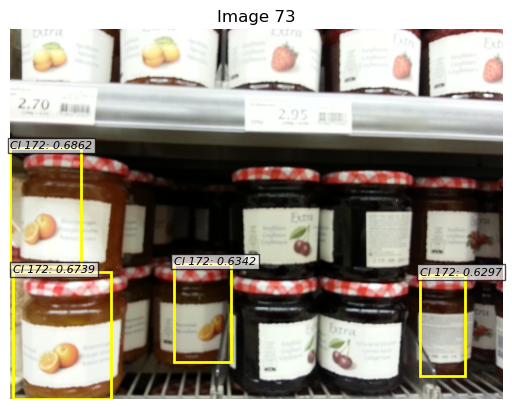

[LCP] 開始基於數學推導的無梯度通道重要性計算 - net_feature_maps.layer1.2.conv1
[415, 393, 77]
[LOG] 原始網路特徵提取完成
[LOG] 剪枝網路特徵提取完成
415 {'channels': [{'l1_norm': 2.1128385066986084, 'variance': 0.36620932817459106, 'mean_deviation': 1.783610224723816, 'energy': 4.8214335441589355, 'sparsity': 0.0, 'importance': 1.917575478553772}, {'l1_norm': 0.9773130416870117, 'variance': 0.4189545810222626, 'mean_deviation': 0.5812510251998901, 'energy': 1.244109034538269, 'sparsity': 0.0, 'importance': 0.8226940631866455}, {'l1_norm': 0.7156198620796204, 'variance': 0.8533787131309509, 'mean_deviation': 0.48392805457115173, 'energy': 0.8779581189155579, 'sparsity': 0.0, 'importance': 0.756942629814148}, {'l1_norm': 0.5647392868995667, 'variance': 0.5304547548294067, 'mean_deviation': 0.3604685664176941, 'energy': 0.5315623879432678, 'sparsity': 0.0, 'importance': 0.5727231502532959}, {'l1_norm': 1.4523136615753174, 'variance': 1.084614634513855, 'mean_deviation': 1.6019575595855713, 'energy': 2.7097904682159424, 'sparsit

C:\Users\marti\os2d-in-Channel-Prune\os2d\engine\objective.py:275: UserWarning: Number of positives in a batch cannot be zero, can't normalize this way, setting num_pos to 1
  warnings.warn("Number of positives in a batch cannot be zero, can't normalize this way, setting num_pos to 1")


[LCP Debug] Computing auxiliary loss...
[LCP Debug] batch_idx is None: False
[LCP Debug] aux_net is None: False
[Memory] 函數開始: 已分配 4.39 GB, 已保留 5.33 GB
[Memory] 獲取 image_ids 後: 已分配 4.39 GB, 已保留 5.33 GB
Image 154 size FeatureMapSize(w=2448, h=3264) has 14 boxes
Image 138 size FeatureMapSize(w=3264, h=2448) has 12 boxes
Image 668 size FeatureMapSize(w=2448, h=3264) has 11 boxes
Image 99 size FeatureMapSize(w=2448, h=3264) has 5 boxes
[Memory] 批次資料解包後: 已分配 4.39 GB, 已保留 4.63 GB
[LCP Debug] class_ids type: <class 'list'>
[LCP Debug] class_ids length: 15
[LCP Debug] class_ids[0] type: <class 'numpy.int64'>
[Memory] 處理 image_id 0: 已分配 4.39 GB, 已保留 4.63 GB
[LCP Debug] Sample 1: aux_loss = 4.978289
[LCP Debug] Sample 2: aux_loss = 4.466864
[Memory] 批次資料清理後: 已分配 4.39 GB, 已保留 4.63 GB
[LCP Debug] Total samples processed: 2/4
[LCP Debug] Average auxiliary loss: 4.722576
[Memory] 函數結束: 已分配 4.39 GB, 已保留 4.63 GB
[Memory] 最終清理後: 已分配 4.39 GB, 已保留 4.63 GB
[LCP Loss] Original loss: 0.294782 (valid: True)


C:\Users\marti\os2d-in-Channel-Prune\os2d\engine\objective.py:275: UserWarning: Number of positives in a batch cannot be zero, can't normalize this way, setting num_pos to 1
  warnings.warn("Number of positives in a batch cannot be zero, can't normalize this way, setting num_pos to 1")


[LCP Debug] Computing auxiliary loss...
[LCP Debug] batch_idx is None: False
[LCP Debug] aux_net is None: False
[Memory] 函數開始: 已分配 4.93 GB, 已保留 6.11 GB
[Memory] 獲取 image_ids 後: 已分配 4.93 GB, 已保留 6.11 GB
Image 647 size FeatureMapSize(w=2448, h=3264) has 16 boxes
Image 670 size FeatureMapSize(w=3264, h=2448) has 12 boxes
Image 550 size FeatureMapSize(w=2448, h=3264) has 10 boxes
Image 594 size FeatureMapSize(w=3264, h=2448) has 21 boxes
[Memory] 批次資料解包後: 已分配 4.93 GB, 已保留 5.14 GB
[LCP Debug] class_ids type: <class 'list'>
[LCP Debug] class_ids length: 14
[LCP Debug] class_ids[0] type: <class 'numpy.int64'>
[Memory] 處理 image_id 0: 已分配 4.93 GB, 已保留 5.14 GB
[LCP Debug] Sample 1: aux_loss = 4.466234
[Memory] 批次資料清理後: 已分配 4.93 GB, 已保留 5.14 GB
[LCP Debug] Total samples processed: 1/4
[LCP Debug] Average auxiliary loss: 4.466234
[Memory] 函數結束: 已分配 4.93 GB, 已保留 5.14 GB
[Memory] 最終清理後: 已分配 4.93 GB, 已保留 5.14 GB
[LCP Loss] Original loss: 1.314606 (valid: True)
[LCP Loss] Auxiliary loss: 4.466234 (val

[2025-07-18 10:12:40,545] [LCP.FineTune] [INFO] LCP Fine-tune 完成


🖥️  GPU 設備: NVIDIA GeForce GTX 1650 Ti
📊 記憶體使用情況:
   已分配: 0.19 GB
   已保留: 3.44 GB
   總容量: 4.00 GB
   使用率: 4.8%
   保留率: 86.0%
   [░░░░░░░░░░░░░░░░░░░░] 4%
剪枝後網路狀態 (第 5, layer1.2.conv1 層):
原始網路參數統計:

總參數量: 10,169,478
可訓練參數量: 10,169,478
模型存儲大小: 39.05 MB
剪枝網路參數統計:

總參數量: 10,013,418
可訓練參數量: 10,013,418
模型存儲大小: 38.45 MB
image to show size: (3264, 2448), res


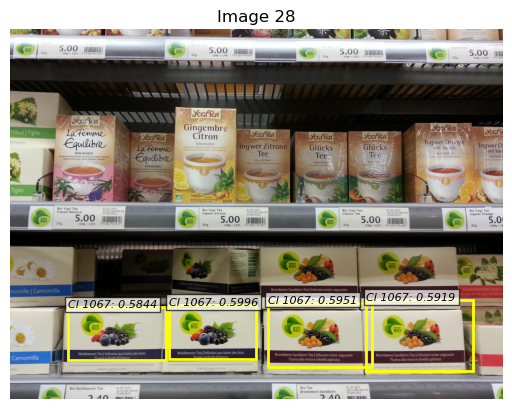

[LCP] 開始基於數學推導的無梯度通道重要性計算 - net_feature_maps.layer1.2.conv2
[415, 393, 77]
[LOG] 原始網路特徵提取完成
[LOG] 剪枝網路特徵提取完成
415 {'channels': [{'l1_norm': 0.3893221914768219, 'variance': 0.2761954367160797, 'mean_deviation': 0.11551950871944427, 'energy': 0.28252288699150085, 'sparsity': 0.0, 'importance': 0.6458329558372498}, {'l1_norm': 0.4339432418346405, 'variance': 0.3149402141571045, 'mean_deviation': 0.023516934365034103, 'energy': 0.31509286165237427, 'sparsity': 0.0, 'importance': 0.6718959808349609}, {'l1_norm': 1.1939096450805664, 'variance': 0.05267398804426193, 'mean_deviation': 1.1565872430801392, 'energy': 1.4748468399047852, 'sparsity': 0.0, 'importance': 1.7513831853866577}, {'l1_norm': 0.362318754196167, 'variance': 0.22696760296821594, 'mean_deviation': 0.07481754571199417, 'energy': 0.23923803865909576, 'sparsity': 0.0, 'importance': 0.5746700167655945}, {'l1_norm': 0.5623247027397156, 'variance': 0.5514188408851624, 'mean_deviation': 0.15227723121643066, 'energy': 0.56494420766830

C:\Users\marti\os2d-in-Channel-Prune\os2d\engine\objective.py:275: UserWarning: Number of positives in a batch cannot be zero, can't normalize this way, setting num_pos to 1
  warnings.warn("Number of positives in a batch cannot be zero, can't normalize this way, setting num_pos to 1")


[LCP Debug] Computing auxiliary loss...
[LCP Debug] batch_idx is None: False
[LCP Debug] aux_net is None: False
[Memory] 函數開始: 已分配 4.89 GB, 已保留 6.06 GB
[Memory] 獲取 image_ids 後: 已分配 4.89 GB, 已保留 6.06 GB
Image 505 size FeatureMapSize(w=2448, h=3264) has 26 boxes
Image 251 size FeatureMapSize(w=2448, h=3264) has 37 boxes
Image 582 size FeatureMapSize(w=2448, h=3264) has 9 boxes
Image 674 size FeatureMapSize(w=3264, h=2448) has 8 boxes
[Memory] 批次資料解包後: 已分配 4.89 GB, 已保留 5.11 GB
[LCP Debug] class_ids type: <class 'list'>
[LCP Debug] class_ids length: 15
[LCP Debug] class_ids[0] type: <class 'numpy.int64'>
[Memory] 處理 image_id 0: 已分配 4.89 GB, 已保留 5.11 GB
[LCP Debug] Sample 1: aux_loss = 4.516473
[Memory] 批次資料清理後: 已分配 4.89 GB, 已保留 5.11 GB
[LCP Debug] Total samples processed: 1/4
[LCP Debug] Average auxiliary loss: 4.516473
[Memory] 函數結束: 已分配 4.89 GB, 已保留 5.11 GB
[Memory] 最終清理後: 已分配 4.89 GB, 已保留 5.11 GB
[LCP Loss] Original loss: 0.612368 (valid: True)
[LCP Loss] Auxiliary loss: 4.516473 (valid

In [ ]:
for idx, layer_name in enumerate(layer_names):
    if layer_name == 'layer3.0.conv1' or layer_name == 'layer3.1.conv1' or layer_name == 'layer3.2.conv1' or layer_name == 'layer3.3.conv1' or layer_name == 'layer3.4.conv1' or layer_name == 'layer3.5.conv1':
        continue
    if idx > 13:
        lcp.prune_layer(
            layer_name   = layer_name,
            discard_rate = 0.4,
        )
    else:
        lcp.prune_layer(
            layer_name   = layer_name,
            discard_rate = 0.8,
        )
    lcp_finetune.start_finetune(
        criterion= lcp_criterion,  # 使用自定義損失函數
    )
    show_gpu_memory_usage()
    print(f"剪枝後網路狀態 (第 {idx+1}, {layer_name} 層):")
    show_network_status(lcp._net, lcp_finetune._prune_net)
    lcp._prune_net = lcp_finetune._prune_net  # 更新剪枝網路
    lcp.save_checkpoint_with_pruned_net(
        log_path = './src/util/checkpoints-test3',
        optimizer = optimizer,
        model_name = f"lcp_finetune_{idx+1}_{layer_name}",
        i_iter = cfg.train.optim.max_iter
    )
    lcp.debug_for_test_vision(
        dataloader_train = dataloader_train,
        img_normalization = img_normalization,
        box_coder = box_coder,
        cfg = cfg,
        count = 2
    )
    from PIL import Image

    # 讀取圖片
    img = Image.open("./visualized_images/image_None_.png")
    
    # 存成新檔名
    img.save(f"./visualized_images/{layer_name}.png")


##### The Global Finetune

In [ ]:
show_network_status(lcp._net, lcp._prune_net)

In [ ]:
global_finetune_iter = 20000
cfg.defrost()
cfg.train.optim.max_iter = 100
cfg.freeze()

In [ ]:
for iter in range( int(global_finetune_iter / cfg.train.optim.max_iter) ):
    print(f"Global Finetune Iteration: {iter+1}/{int(global_finetune_iter / cfg.train.optim.max_iter)}")
    lcp_finetune.start_finetune(
        criterion= lcp_criterion,  # 使用自定義損失函數
    )
    lcp.save_checkpoint_with_pruned_net(
        log_path = './src/util/checkpoints-test3',
        optimizer = optimizer,
        model_name = f"lcp_finetune_{iter+1}_global",
        i_iter = cfg.train.optim.max_iter
    )
    lcp._prune_net = lcp_finetune._prune_net  # 更新剪枝網路
    lcp.debug_for_test_vision(
        dataloader_train = dataloader_train,
        img_normalization = img_normalization,
        box_coder = box_coder,
        cfg = cfg,
        count = 2
    )